# Notebook de test des données lapi brutes

In [2]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin\git\Outils\Outils\Martin_Perso')
import donnees_brutes as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import

In [3]:
%time #passages
#df_3semaines=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\df_3semaines.json', orient='index')
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')

Wall time: 0 ns


In [3]:
df_3semaines=df_3semaines.set_index('created').sort_index()

In [25]:
#plaques non chiffrees
df_plaque=t.ouvrir_fichier_lapi_final()

In [26]:
df_plaque.head(5)

,plaque_ouverte,chiffree
0,EH-088-HA,aa7bcc294ae84500cbd106e6bad044b2e567f4f0
1,EV-275-JN,a0af823b4d28f6b80f9c8d6bd344fdfff5dc87d1
2,EV-162-KN,ed628574b784aabe88652fb2bbbd221399d01490
3,EY-476-FY,6e66a18c908e8609798483483a0155011ec0fb4a
4,4038KFJ,6475f41e358e542b3000c36fed8c3335a9deaa29


## 1.2 Traitement des doublons

In [3]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]
#supprimer les doublons
#df_3semaines=df_3semaines.reset_index().drop_duplicates(['created','immat'])

In [9]:
#doublons "proches" : même immat, même camera, passages écartés de moins de 10s
df_3semaines=df_3semaines.sort_values(['immat','created','camera_id','fiability']).copy()
df_3semaines['id']=(df_3semaines.created - df_3semaines.created.shift(1) > pd.Timedelta(seconds=10)).fillna(99999999).cumsum(skipna=False)
df_3semaines=df_3semaines.sort_values(['immat','id','fiability'], ascending=False).copy().drop_duplicates(['immat','id'])

In [10]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]


Wall time: 4min 42s
Parser   : 999 ms


In [ ]:
groupe_pl_rappro.head(5)#.merge(df_plaque, left_index=True, right_on='chiffree')

In [17]:
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()

49116

In [7]:
df_triee.loc[(df_triee['immat']=='0000e1c43055e27ee50ad15070aa82fda0a648c8') & (df_triee['created'].between(
pd.to_datetime('2019-01-29 06:15:40'),pd.to_datetime('2019-01-30 12:15:40')))]

,created,camera_id,immat,fiability,l,state,id
339901,2019-01-29 06:15:44,3,0000e1c43055e27ee50ad15070aa82fda0a648c8,89,-1,FR,42
657050,2019-01-30 06:37:16,3,0000e1c43055e27ee50ad15070aa82fda0a648c8,79,-1,FR,43
657056,2019-01-30 06:37:18,3,0000e1c43055e27ee50ad15070aa82fda0a648c8,89,0,FR,43
741375,2019-01-30 11:02:46,18,0000e1c43055e27ee50ad15070aa82fda0a648c8,89,1,FR,44


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

# 2. Création des trajets
## 2.1 Listes des trajets
>Listes créées à la main au départ, puis sauvegardée dans un fichier json.<br> Contient la liste des trajets "complet" i.e avec la camera de début et de fin, et la liste des trajets "incomplet" i.e où il peut manquer la camera de debut ou de fin (**attention, pour le moement le cas de A63 est traité à part pour le cas incomplet, car en fait les cas incomplet A63 renvoi un trajet de transit qui s'arrete à A660**).<br> on ajoute ensuite les données de longueur et tempsdeparcours théorique, sur la base d'un vitesse pl motyenne de 80 km/h pour vavoir un peu de marge

In [7]:
liste_complete_trajet=pd.read_json(r'E:\Boulot\lapi\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [5]:
liste_complete_trajet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
13,13,12,"(12, 6, 3, 18, 13)",A63,105.139253,5,A10-A63,A10,01:18:51.266000
12,13,12,"(12, 6, 2, 18, 13)",A63,108.707013,5,A10-A63,A10,01:21:31.815000
56,7,15,"(15, 19, 4, 7)",A89,90.709158,4,A63-A89,A63,01:08:01.912000
36,11,10,"(10, 4, 5, 11)",A10,64.969553,4,A62-A10,A62,00:48:43.629000
31,13,6,"(6, 3, 18, 13)",A63,85.355597,4,N10-A63,N10,01:04:01.001000
25,5,15,"(15, 19, 1, 5)",N10,89.925738,4,A63-N10,A63,01:07:26.658000
24,5,15,"(15, 19, 4, 5)",N10,85.048763,4,A63-N10,A63,01:03:47.194000
30,13,6,"(6, 2, 18, 13)",A63,88.923357,4,N10-A63,N10,01:06:41.551000


In [8]:
liste_trajet_incomplet=pd.DataFrame(np.array([[4, 15, (15,19,4), 'N10',85.048763,3,'A63-N10','A63','01:03:47.194000'], 
                                              [1, 15, (15,19,1), 'N10',89.925738,3,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,4), 'N10',85.048763,2,'A63-N10','A63','01:03:47.194000'],
                                              [1, 15, (15,1), 'N10',89.925738,2,'A63-N10','A63','01:07:26.658000'],
                                              [4, 15, (15,19,4), 'A89',90.709158,3,'A63-A89','A63','01:08:01.912000'],
                                              [4, 15, (15,4), 'A89',90.709158,2,'A63-A89','A63','01:08:01.912000'],
                                              [19, 15, (15,19), 'A62',73.187282,2,'A63-A62','A63','00:54:53.427000'],
                                              [4, 10, (10,4), 'N10',29.693103,2,'A62-N10','A62','00:22:16.189000'],
                                              [4, 10, (10,4), 'A89',35.353498,2,'A62-A89','A62','00:26:30.907000'],
                                              [6, 12, (12,6), 'A89',43.113096,2,'A10-A89','A10','00:32:20.089000'],
                                              [3, 12, (12,6,3), 'A62',50.013745,3,'A10-A62','A10','00:37:30.618000'],
                                              [3, 8, (8,3), 'A62',36.003136,2,'A89-A62','A89','00:27:00.141000'],
                                              [3, 6, (6,3), 'A62',30.230090,2,'N10-A62','N10','00:22:40.354000']
                                             ]),
                                    columns=['cam_d', 'cam_o', 'cameras','destination', 'long_km', 'nb_cams','o_d', 'origine', 'tps_parcours_theoriq'])
#liste_trajet_incomplet.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\liste_trajet_incomplet.json', orient='index')
liste_trajet_incomplet=pd.read_json(r'E:\Boulot\lapi\liste_trajet_incomplet.json', orient='index')
liste_trajet_incomplet['cameras']=liste_trajet_incomplet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_trajet_incomplet['tps_parcours_theoriq']=liste_trajet_incomplet.apply(lambda x : pd.Timedelta(x['tps_parcours_theoriq']),axis=1)
liste_trajet_incomplet.sort_values('nb_cams', ascending=False, inplace=True)
liste_trajet_incomplet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,4,15,"(15, 19, 4)",N10,85.048763,3,A63-N10,A63,01:03:47.194000
1,1,15,"(15, 19, 1)",N10,89.925738,3,A63-N10,A63,01:07:26.658000
4,4,15,"(15, 19, 4)",A89,90.709158,3,A63-A89,A63,01:08:01.912000
2,4,15,"(15, 4)",N10,85.048763,2,A63-N10,A63,01:03:47.194000
3,1,15,"(15, 1)",N10,89.925738,2,A63-N10,A63,01:07:26.658000
5,4,15,"(15, 4)",A89,90.709158,2,A63-A89,A63,01:08:01.912000
6,19,15,"(15, 19)",A62,73.187282,2,A63-A62,A63,00:54:53.427000
7,4,10,"(10, 4)",N10,29.693103,2,A62-N10,A62,00:22:16.189000
8,4,10,"(10, 4)",A89,35.353498,2,A62-A89,A62,00:26:30.907000
9,3,8,"(8, 3)",A62,36.003136,2,A89-A62,A89,00:27:00.141000


## 2.2 Constitution de la base des trajets de transit
>obtention de 3 dataframes : 
- contenant les trajets de transit
- contenant les passages de transit
- contenant les temps maxi autorisés pour etre considéré comme transit, et le type detems maxi (cluster ou reglementaire)

### 2.2.1. Base : trajets qui collent avec ceux prévus dans la liste des trajets

In [4]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-28 00:00:00',7,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-09 09:28:17.599342
date : 2019-01-29 00:00:00 debut_traitement : 2019-05-09 09:29:23.701851
date : 2019-01-30 00:00:00 debut_traitement : 2019-05-09 09:30:34.500523
date : 2019-01-31 00:00:00 debut_traitement : 2019-05-09 09:31:46.263730
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-09 09:33:11.263796
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-09 09:34:49.690238
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-09 09:36:39.242573


*important : controle si doublons entre trajets*.<br> pourrait faire l'objet d'une fonction supp

In [ ]:
for destination in ['N10','A10','A63','A660', 'A89', 'A62'] : 
    print (t.verif_doublons_trajet(dico_od, destination))

### 2.2.2. Filtrer les trajets selon un temps de parcours
> Lorsque l'on utilise transit_temps_complet, le dico de stemps max est crée (On regroupe les trajets par Cluster, on utilise une df des parametres à utiliser pour les cluster basée sur des observations perso et un travail à la main). <br> En premier lieu on corrige ce dico des temps max en prenant un moyenne des temps max de type Cluster lorsque ceux ci encadre un temps max de type '85_percentile). <br> Là, on met un attribut drapeau pour identifier les trajets de transit.<br> la fonction graph_transit_filtre_multiple permet de visualiser les trajets de transit sur plusieurs jours, pour une o_d

In [35]:
#pour info : parametres cluster
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
4,1000,4,15,N10-A63


In [36]:
#dico des temps max issus du lapi corrigé avec moyenne cluster
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

In [37]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,liste_complete_trajet, 15)

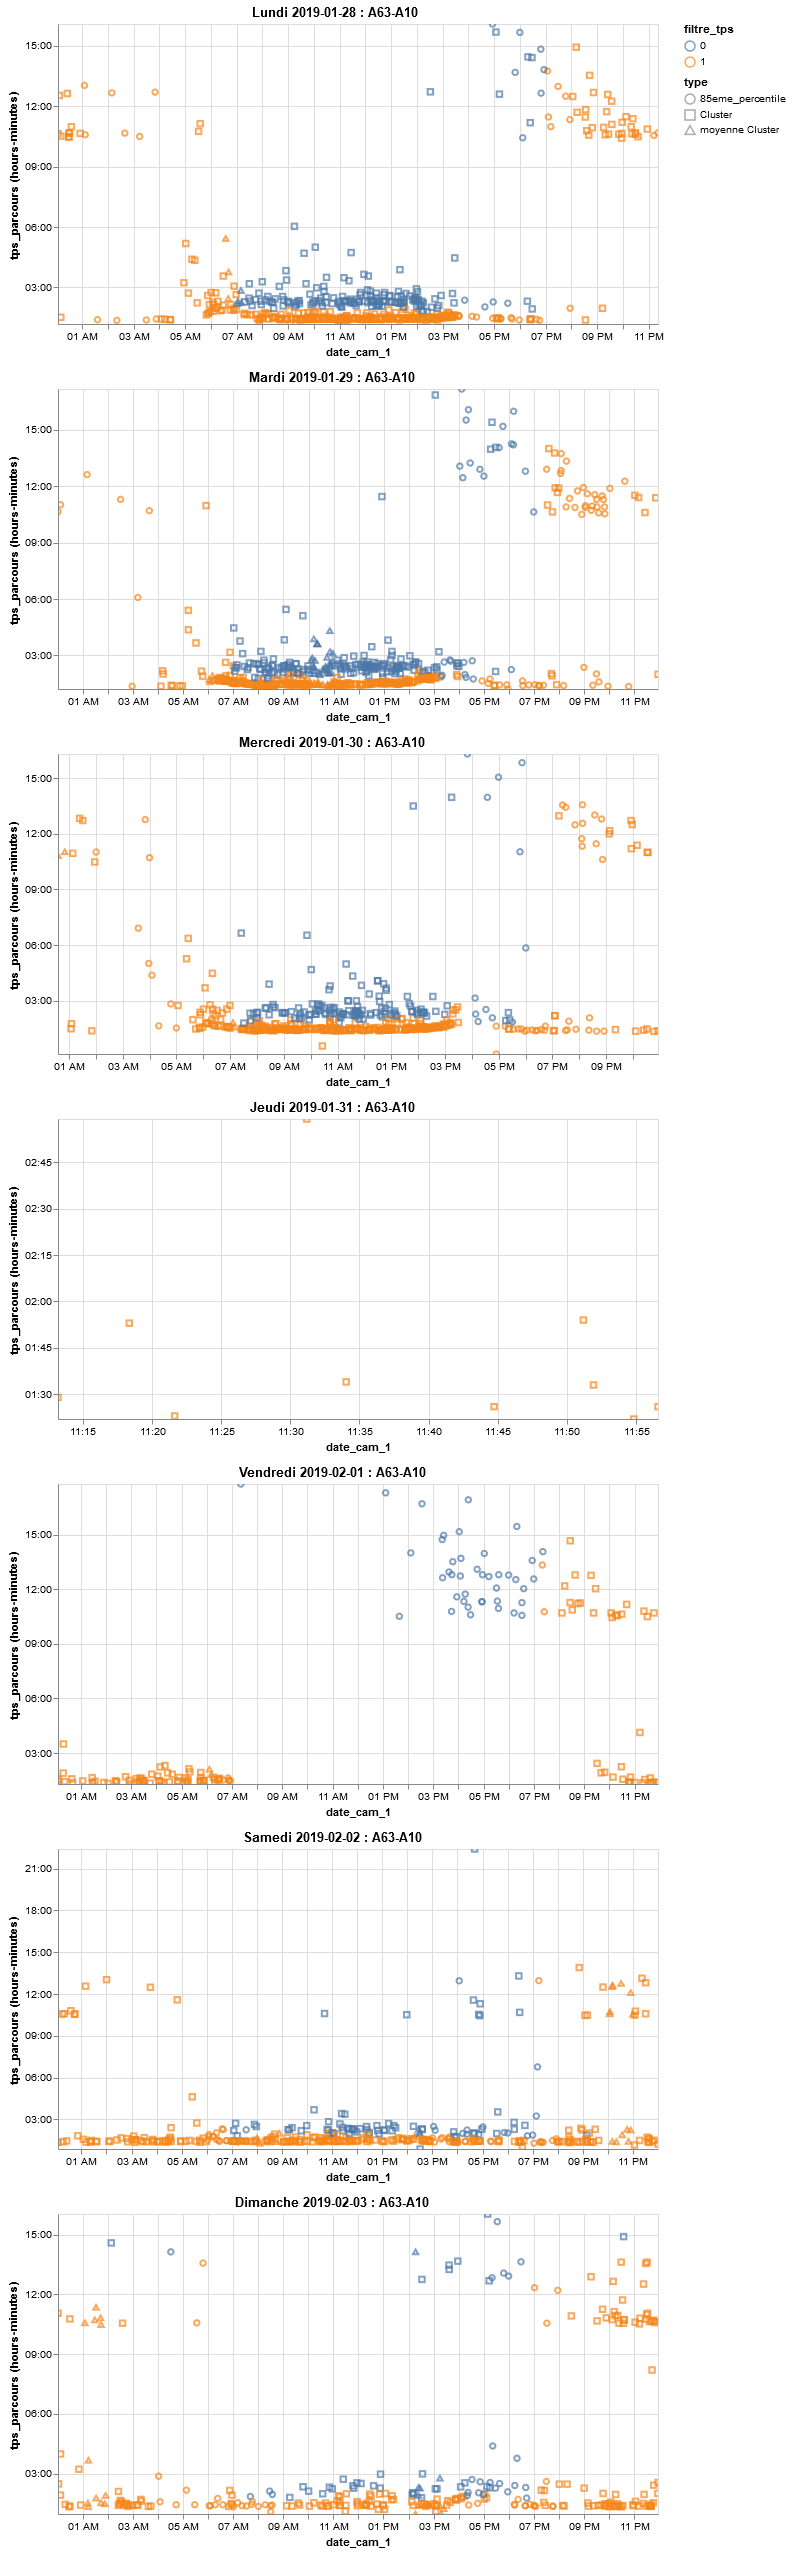

In [13]:
#exemple de visu sur 7 jours
t.graph_transit_filtre_multiple(df_transit_avec_filtre, 
                                '2019-01-28 00:00:00', '2019-01-28 23:59:59', 'A63-A10', 7)

In [38]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

### 2.2.3. Correction des trajets depuis ou vers A660 relatifs à A63
> Il s'agit de corriger les trajets référencé depouis ou vers A660, alors que le vehicules a du passer sur A63 aussi.<br> plusieurs cas : 
- Passer sur A660 et vu avant ou apres sur A63
- Passer que sur A660 dans le sens nord sud puis sud-Nord, avec une immat déja vudans les plaques de transit et plus de 1jours d'ecart entre les passages

In [ ]:
#### A VERIFIER !!!!
%time df_od_corrige=t.correction_trajet(df_3semaines, dico_od_final)
#pour exemple
#df_od_corrige=dico_od_final.copy()
#df_od_corrige['correction_o_d']=False

In [ ]:
#pour retrouver les trajets corrigé : 
df_od_corrige.loc[df_od_corrige['correction_o_d']==True]

### 2.2.4. extrapolation des trajets non complets
> pour les véhicules qui ont déja été identifié comme faisant du transit.**<br>Attention : <br>ce travail se base sur le fait qu'un véhicule qui parcoure un trajet incomplet doit forcément revenir sur le dispositif par un point d'entrée LAPI(cam 15,6,8,10,12)**<br>*un test pourrait etre mené pour illustrer le nb de pl qui ne font pas de transit : cf ligne de code :* <br>#POUR TEST !!!!!<br> #trajet_transit_incomplet=trajets_possible_enrichi <br>de la fonction transit_trajet_incomplet

In [ ]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-28 00:00:00',df_od_corrige,df_3semaines,dico_passag)

In [157]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,df_non_transit,'2019-01-28 00:00:00',1,df_3semaines)

date : 2019-01-28 00:00:00 debut_traitement : 2019-05-06 17:05:57.323329
Wall time: 43.3 s


In [158]:
trajet_transit_incomplet2

,date_cam_1,immat,state,l,date_cam_2,o_d_immat,Nb_occ,cameras,origine,destination,o_d,tps_parcours,cam_suivant,date_suivant
0,2019-01-28 00:36:41,94e39baa499f9c4a668b6e4591eb6efd848ccf45,ES,1,2019-01-28 01:25:14,A63-N10,2,"(15, 4)",A63,N10,A63-N10,00:48:33,6.0,2019-01-28 15:54:34
0,2019-01-28 05:00:02,004bb0ee9dc5a6f1651f22537d4127b5379f68e3,FR,1,2019-01-28 06:41:43,A62-N10,2,"(10, 4)",A62,N10,A62-N10,01:41:41,6.0,2019-01-28 13:14:10
0,2019-01-28 13:20:27,eaec81170774b0d1b8c4715d4c2a3316e4cbecdf,FR,1,2019-01-28 13:45:42,A10-A62,2,"(12, 6, 3)",A10,A62,A10-A62,00:25:15,10.0,2019-01-28 16:36:20
0,2019-01-28 14:44:42,f390910ed0c50ca644ffb2b40531ac22d2470cc9,FR,1,2019-01-28 15:35:59,A63-N10,3,"(15, 19, 4)",A63,N10,A63-N10,00:51:17,6.0,2019-01-29 07:53:36


In [186]:
#filtrer selon le temps de parcours
trajet_transit_incomplet_filtre_temps=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,liste_trajet_incomplet, 15,'incomplet')
#mettre en forme les attributs
trajet_transit_incomplet_filtre_temps=trajet_transit_incomplet_filtre_temps[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq', 'filtre_tps']]
#filtrer le df : 
trajet_transit_incomplet_final=trajet_transit_incomplet_filtre_temps.loc[trajet_transit_incomplet_filtre_temps['filtre_tps']==1]

In [187]:
#ajouter l'attribut d'identification des trajets 
trajet_transit_incomplet_final['correction_o_d']=True
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,trajet_transit_incomplet_final])

# 3. CREER LE TABLEAU DE MATRICE O-D

In [40]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2763,2402,1618,188,NC,6971
A62,1007,NC,125,522,274,1158,3086
A63,1782,88,NC,NC,479,11113,13462
A660,1112,471,NC,NC,912,3480,5975
A89,158,414,751,1088,NC,NC,2411
N10,NC,1377,9396,2934,NC,NC,13707
All,4059,5113,12674,6162,1853,15751,45612


## 4. Nb VL, PL et PL en transit par Plage Horaire et caméra

In [120]:
#calcul des nb vl, pl et PL en transit par heure et camera
test=t.pourcentage_pl_camera(df_3semaines,dico_passag)

In [123]:
#selection df pour graphique
pour_graph=jointure_pct_pl.loc[(test.apply(lambda x : x['created'].dayofyear==pd.to_datetime('2019-01-31').dayofyear,axis=1))
                              &(test['camera_id']==4)]

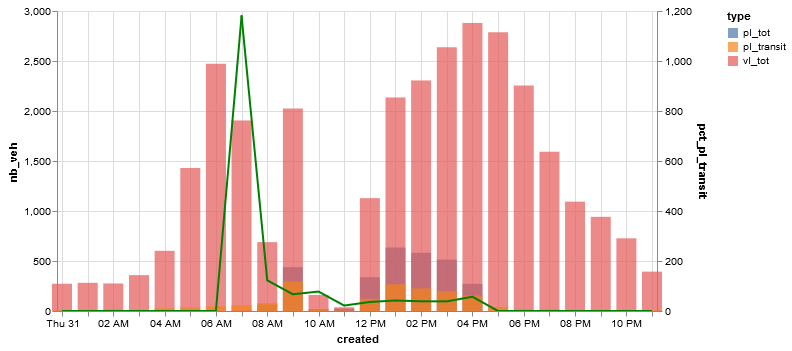

In [122]:
#graphique
base=alt.Chart(pour_graph).encode(x='created')
bar = base.mark_bar(opacity=0.7, size=20).encode(y=alt.Y('nb_veh:Q',stack=None),color='type')
line=base.mark_line(color='green').encode(y='pct_pl_transit:Q')
(bar+line).resolve_scale(y='independent').properties(width=600)

VERIFICATION

In [145]:
#retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='179431c252468bd1d6fb47b8170df64b2d65a960']

,camera_id,immat,fiability,l,state
created,,,,,
2019-01-28 00:41:39,15,179431c252468bd1d6fb47b8170df64b2d65a960,89,0,PT
2019-01-28 01:11:45,19,179431c252468bd1d6fb47b8170df64b2d65a960,89,0,PT
2019-01-28 01:29:53,4,179431c252468bd1d6fb47b8170df64b2d65a960,99,0,PT
2019-01-28 01:40:35,5,179431c252468bd1d6fb47b8170df64b2d65a960,99,0,PT
2019-01-30 08:05:46,3,179431c252468bd1d6fb47b8170df64b2d65a960,89,1,PT
2019-01-30 08:36:14,18,179431c252468bd1d6fb47b8170df64b2d65a960,89,0,PT
2019-02-02 08:43:46,15,179431c252468bd1d6fb47b8170df64b2d65a960,89,-1,PT
2019-02-02 09:14:06,19,179431c252468bd1d6fb47b8170df64b2d65a960,89,0,PT
2019-02-02 09:34:25,4,179431c252468bd1d6fb47b8170df64b2d65a960,89,0,PT


In [84]:
#retrouver les cameras et date avant / apres un passage
def cam_voisines(immat, date, camera, df_immat) :
    """
    Retrouver les dates et camera de passages d'un vehicule avant et apres un passage donne
    en entree : 
        immat : string : immatribualtion
        date : string : date de passage
        camera : cam de passage
        df_immat : df des immats concernees (limiter le df_3semainee)
    """
    passage_immat=df_immat.loc[df_immat['immat']==immat].reset_index().copy()
    idx=passage_immat.loc[(passage_immat['created']==date) & (passage_immat['camera_id']==camera)].index
    cam_suivant, date_suivant=passage_immat.shift(-1).iloc[idx]['camera_id'].values[0], passage_immat.shift(-1).iloc[idx]['created'].values[0]
    cam_precedent, date_precedent=passage_immat.shift(1).iloc[idx]['camera_id'].values[0], passage_immat.shift(1).iloc[idx]['created'].values[0]
    return cam_suivant,date_suivant, cam_precedent,date_precedent


In [139]:

toto=df_3semaines.loc[pd.to_datetime('2019-02-01 09:00:00'):pd.to_datetime('2019-02-04 22:00:00')]
toto.loc[toto['camera_id']==11]

,camera_id,immat,fiability,l,state
created,,,,,
2019-02-01 23:00:51,11,a1a9148b72647a6aeb97219e0ece325b04a18c18,99,0,FR
2019-02-01 23:01:35,11,0a6309f51c40e3dba00b441dbb8c1a5a784e4c6a,99,0,FR
2019-02-01 23:01:47,11,bd9b1bc1bd72453a41baae0909a40aea0e009e4f,99,0,FR
2019-02-01 23:02:04,11,b2fe2ec5da89e6a74424375fdedd88ce4c83e87e,58,0,FR
2019-02-01 23:02:24,11,55dce112f48dc9811d985e9ed11b9d0ea7caf442,59,0,FR
2019-02-01 23:02:37,11,d9498bd1085e16e8e534abbc47f2ff78bacfdffe,99,0,FR
2019-02-01 23:04:15,11,9f45540c24b3534beb0beeae7d597de5f63f67ac,99,0,FR
2019-02-01 23:04:55,11,a895e9993249b44e116002dad11030555b53b657,99,0,ES
2019-02-01 23:05:28,11,6424572aa102be183ac14bcbcd1ded817fc1a79d,99,0,FR


In [54]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period
18,2019-01-29 07:44:45,b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0,ES,1,2019-01-29 09:10:44,"(6, 18, 13)",N10,A63,N10-A63,01:25:59,2019-01-29 07:30


In [130]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-02-01 00:00:00':'2019-02-02 23:59:59'], '2019-02-01 09:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
test.df_transit.loc[test.df_transit['o_d']=='A63-A10']

,date_cam_1,immat,state,l,date_cam_2,cameras,origine,destination,o_d,tps_parcours


TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

In [47]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

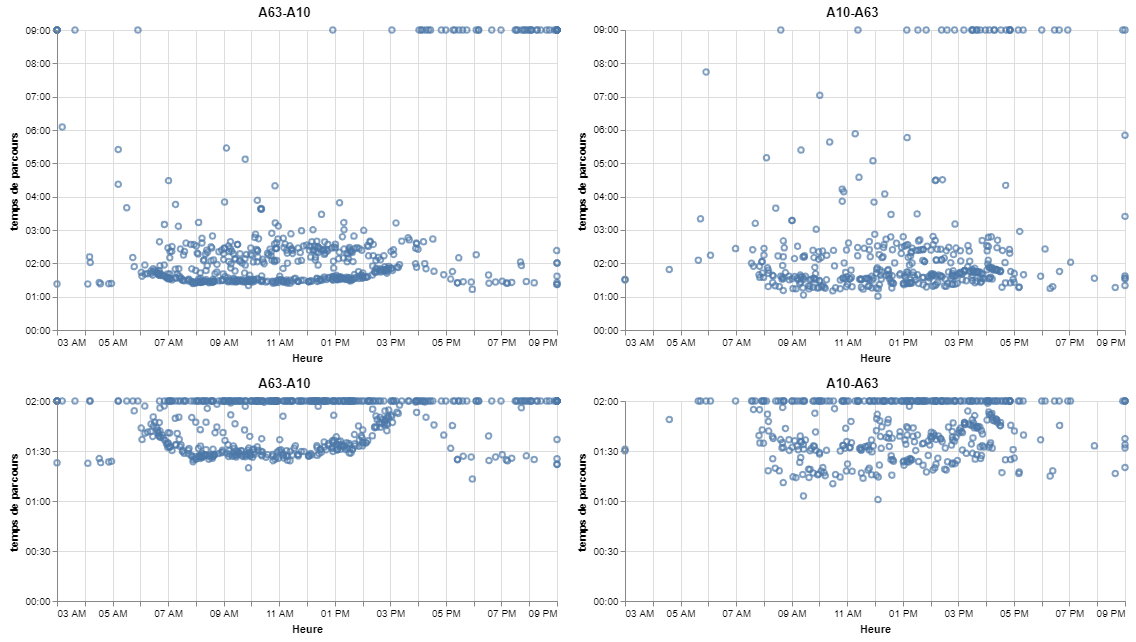

In [71]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A10-A63'], title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-A10'], title='A63-A10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

In [193]:
param_cluster=pd.DataFrame({'trajet':[('A10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('N10-A63')
                       ],
              'temps_etudie':[15,60,15,60,15],
              'delai':[600,1200,800,1000,1000],
              'nb_pt_min':[4,4,3,4,4]
             })
param_cluster.to_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [55]:
param_cluster=pd.read_json(r'E:\Boulot\lapi\param_cluster.json', orient='index')
param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"


In [278]:
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 10:00:00', 60, [15,11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [126]:
alt.Chart(df_3semaines.reset_index().loc[(df_3semaines.reset_index()['created'].between('2019-01-27 00:00:00', '2019-01-27 23:59:59')) & 
                 (df_3semaines['camera_id']==4)].set_index('created').resample('H').count().reset_index(),title='27/01 cam 4').mark_bar().encode(
                   x='created',
                    y='immat' )

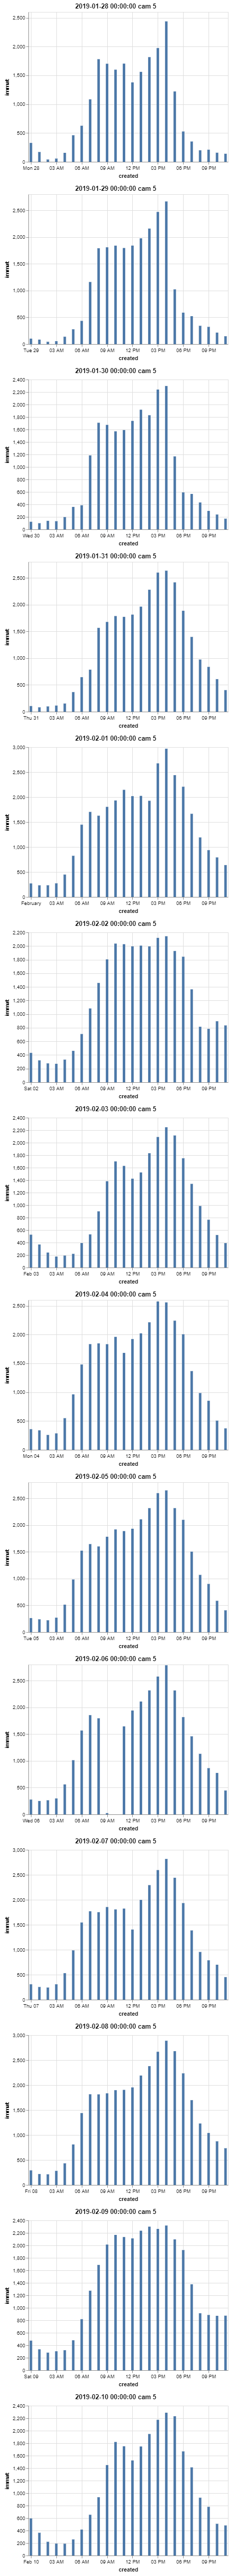

In [25]:
t.graph_nb_veh_jour_camera_multi_j(df_3semaines,'2019-01-28 00:00:00','2019-01-28 23:59:59',5,14).save('E:\Boulot\lapi\image_nb_veh_J')